#  Project Proposal - Predicting Heart Disease
Group Members: Chengyuan Yao, Eunji Hwang, Lina Anwari, Duffy Du
# Table of Contents:
1. [Introduction](#introduction)
2. [Preliminary exploratory data analysis](#prelim-data)
3. [Methods](#methods)
4. [Expected outcomes and significance](#outcome-significance)


# 1.0 Introduction <a id='introduction'></a>

Heart disease is a leading cause of death globally and is linked to several factors such as obesity, smoking, and numerous more. For our classification model, we use the Heart Disease Data Set, specifically the Cleveland database, which contains information collected by Robert Detrano from the Cleveland Clinic Foundation. It is based on anonymous real-life patients’ records, and each row represents a different patient based on the 14 categories. Our question is, is there a relationship that predicts the diagnosis of heart disease? (based on numerical variables below)

Variables/Descriptions:

- age - age in years   

- trestbps - resting blood pressure (mm Hg)

- chol - serum cholesterol (mg/dl)

- thalach - maximum heart rate

- oldpeak - ST depression induced by exercise

# <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.0 Preliminary Exploratory Data Analysis<a id='prelim-data'></a>

In [30]:
#Loaded Libraries

library(tidyverse)
library(repr)
library(tidymodels)
library(caret)
install.packages("expss")
library(expss)
library(ggplot2)
library(GGally)
library("gridExtra")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



## <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.1 Reading and Checking data





In [31]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                           col_names = c("age", 
                                         "sex", 
                                         "cp", 
                                         "trestbps", 
                                         "chol", 
                                         "fbs", 
                                         "restercg", 
                                         "thalach", 
                                         "exang", 
                                         "oldpeak", 
                                         "slope", 
                                         "ca", 
                                         "thal", 
                                         "num"))
cleveland_data$num <- as.factor(cleveland_data$num)
head(cleveland_data)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restercg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,trestbps,chol,fbs,restercg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [32]:
# see if there is other number rather than 0-4 in the num column
cleveland_data  %>%
    select(num)  %>% 
    unlist() %>% 
    levels()


[1] "0" "1" "2" "3" "4"

In [33]:
# transform num from 0-4 to 0 or 1 (1, 2, 3, 4) and store into diagnosis variable
cleveland_data <- cleveland_data %>%
                  mutate(diagnosis = dplyr::recode(num, '0' = 'absent', .default = 'present'))
head(cleveland_data)

age,sex,cp,trestbps,chol,fbs,restercg,thalach,exang,oldpeak,slope,ca,thal,num,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,absent
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,present
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,present
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,absent
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,absent
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,absent


As the result we get correct data in the diagnosiscolumn

In [34]:
# to see how the original data distribute
cleveland_data %>% 
    group_by(diagnosis) %>%
    summarize(n = n())


`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,n
<fct>,<int>
absent,164
present,139


## <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.2 Tidy the data

In [35]:
# We select all the numerical columns and diagnosis column
cleveland_data2 <- cleveland_data%>%
            select(age, trestbps, chol, thalach, oldpeak, diagnosis)
head(cleveland_data2)

age,trestbps,chol,thalach,oldpeak,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,absent
67,160,286,108,1.5,present
67,120,229,129,2.6,present
37,130,250,187,3.5,absent
41,130,204,172,1.4,absent
56,120,236,178,0.8,absent


In [36]:
# split the data into trainning and testing (ratio = 3:1)
set.seed(2022) 
heart_split <- initial_split(cleveland_data2, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [37]:
# Summary statistics (max, min, mean, median and SD) of numerical variables
summary_data <-heart_train %>%
                apply_labels(age= "age",
                            trestbps = "trestbps",
                            chol = "chol",
                            thalach = "thalach",
                            oldpeak = "oldpeak")
                             
summary_table <- summary_data %>%
                 tab_cells(age, trestbps, chol, thalach, oldpeak) %>%
                 tab_cols(total(label = "Summary Statistics"))  %>%
                 tab_stat_fun(Max = w_max, Min = w_min, Mean = w_mean, "Median" = w_median, "Standand Deviation " = w_sd, method = list) %>%
                tab_pivot()
summary_table

|          | Summary Statistics |     |       |        |                     |
 |          |                Max | Min |  Mean | Median | Standand Deviation  |
 | -------- | ------------------ | --- | ----- | ------ | ------------------- |
 |      age |               77.0 |  29 |  54.7 |   56.0 |                 9.1 |
 | trestbps |              200.0 |  94 | 132.2 |  130.0 |                18.3 |
 |     chol |              564.0 | 131 | 249.3 |  244.0 |                52.4 |
 |  thalach |              202.0 |  96 | 150.7 |  154.0 |                22.2 |
 |  oldpeak |                4.4 |   0 |   1.0 |    0.8 |                 1.1 |

##  <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3 Graphs of Relationships
 

We use two standards to choose predictors:
1) independent from other explanatory variables.

2) related to the responsible variable. 

The first standard avoids collinearity which decreases the predictive power of the model. For the second standard, we only choose the explanatory variables that are related to the responsible variable to ensure all predictors will contribute sufficiently significant predictive power to our model, which maintains a balance between accuracy and simplicity

###  <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3.1 Graphs of Explanatory Variables Versus Each Other <a id='exp-exp'></a>

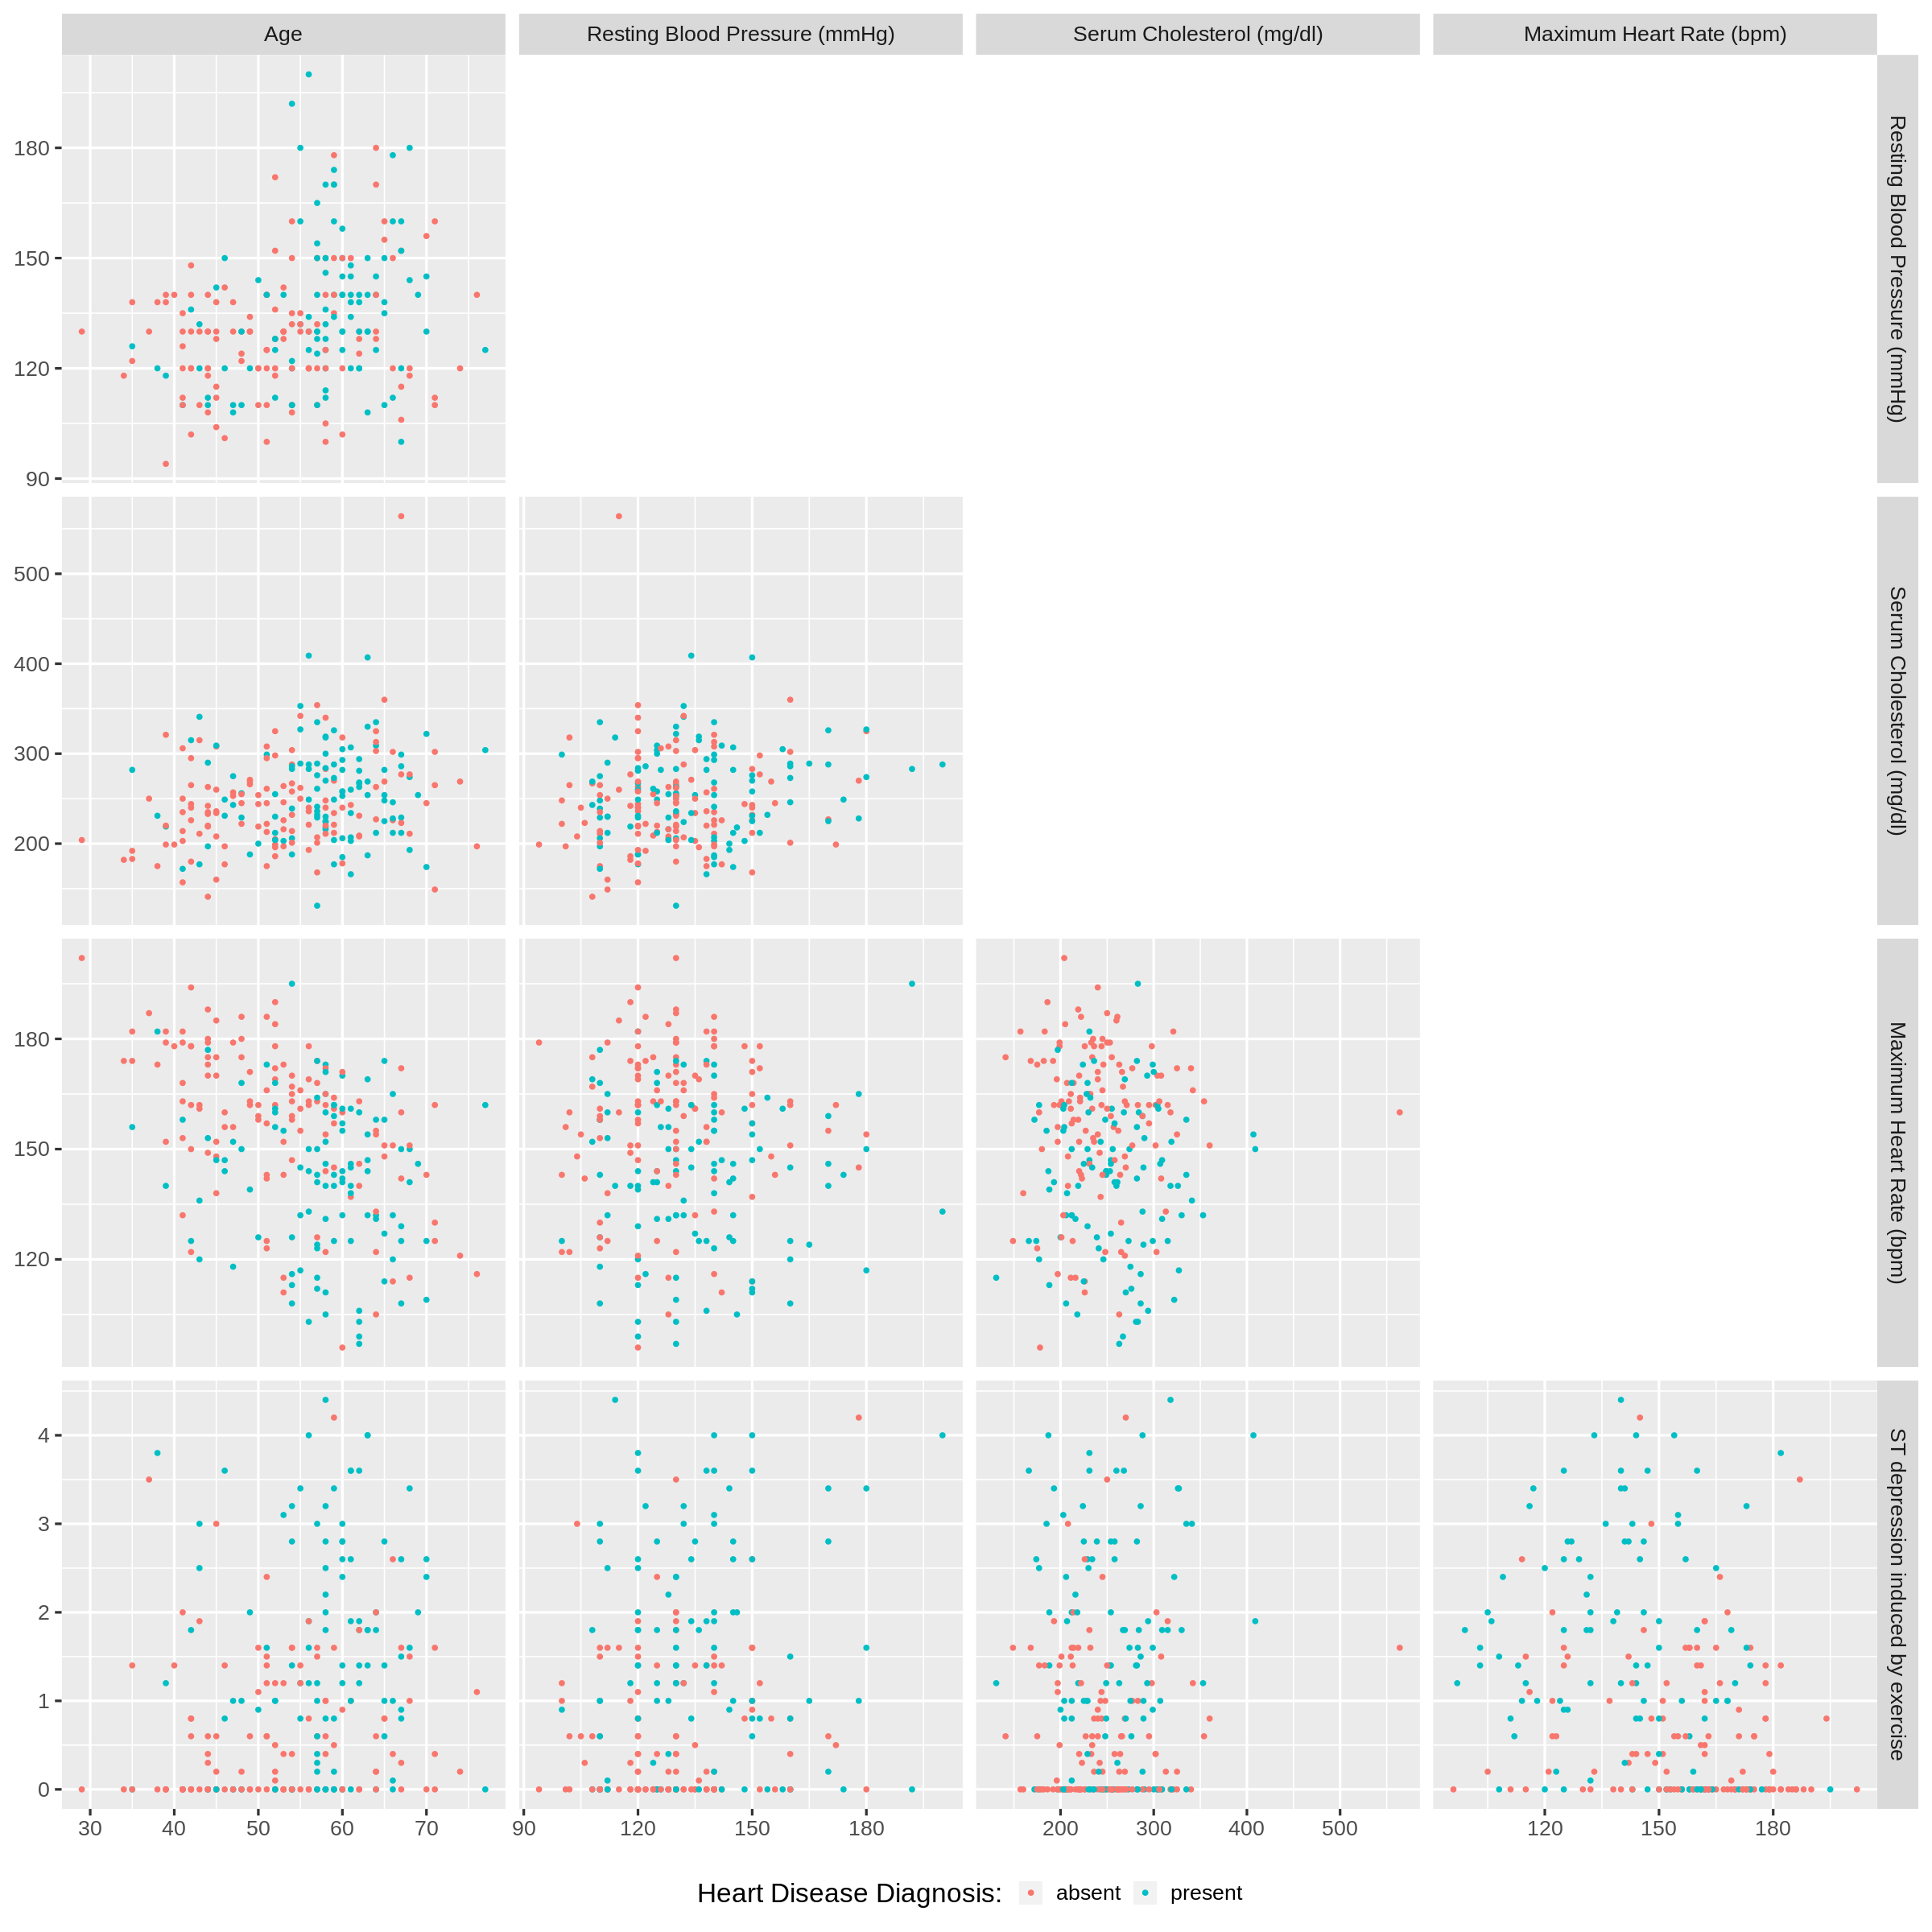

In [38]:
options(repr.plot.width = 20, repr.plot.height = 20) 

plot_pairs <- heart_train %>% 
  select(age, trestbps, chol, thalach, oldpeak, diagnosis) %>% 
  ggpairs(legend = 6,
          columns = 1:5,
          mapping = ggplot2::aes(color = diagnosis),
          columnLabels = c("Age", "Resting Blood Pressure (mmHg)", "Serum Cholesterol (mg/dl)", "Maximum Heart Rate (bpm)", "ST depression induced by exercise"),
          diag = NULL,
          upper = "blank"
          ) +
          labs(color = "Heart Disease Diagnosis: ") +
          theme(axis.text.x = element_text(hjust = 1, color = "black", size = 20),
                axis.text.y = element_text(hjust = 1, color = "black", size = 20)) +
          theme_grey(base_size = 20)+
          theme(legend.position = "bottom")  

# function to remove top most and right most row/column
gpairs_lower <- function(g){
  g$plots <- g$plots[-(1:g$nrow)]
  g$yAxisLabels <- g$yAxisLabels[-1]
  g$nrow <- g$nrow -1

  g$plots <- g$plots[-(seq(g$ncol, length(g$plots), by = g$ncol))]
  g$xAxisLabels <- g$xAxisLabels[-g$ncol]
  g$ncol <- g$ncol - 1

  g
}

gpairs_lower(plot_pairs)

### <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3.2 Explanatory Variables vs. Heart Disease Diagnosis<a id='var-diag'></a>

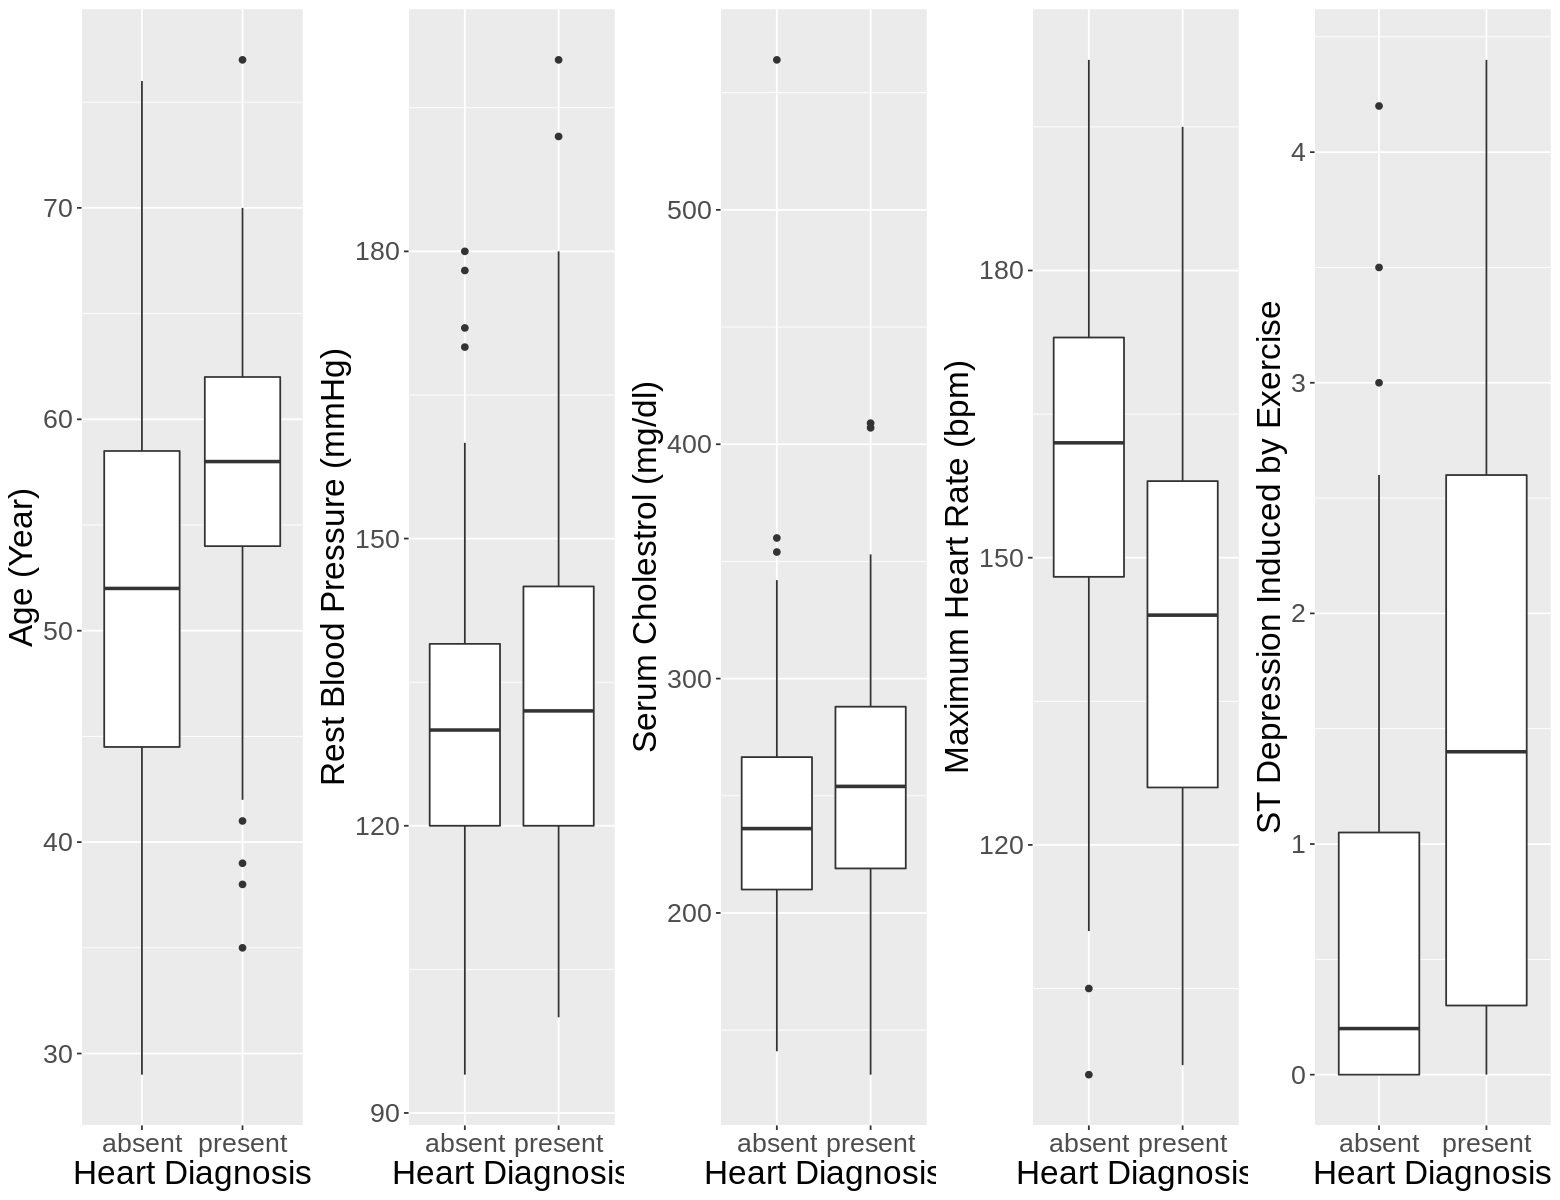

In [39]:
# age, trestbps, chol, thalach, oldpeak vs diagnosis

options(repr.plot.width = 13, repr.plot.height = 10)

age_diag_plot <- ggplot(heart_train,aes(y=age,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="Age (Year)") +
    theme(text=element_text(size=20))


trestbps_diag_plot <- ggplot(heart_train,aes(y=trestbps,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="Rest Blood Pressure (mmHg)") +
    theme(text=element_text(size=20))


chol_diag_plot <- ggplot(heart_train,aes(y=chol,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="Serum Cholestrol (mg/dl)") +
    theme(text=element_text(size=20))


thalach_diag_plot <- ggplot(heart_train,aes(y=thalach,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="Maximum Heart Rate (bpm)") +
    theme(text=element_text(size=20))


oldpeak_diag_plot <- ggplot(heart_train,aes(y=oldpeak,x=diagnosis)) +
    geom_boxplot()+
    labs(x="Heart Diagnosis", y="ST Depression Induced by Exercise")+
    theme(text=element_text(size=20))

combined_diag_plot <- grid.arrange(age_diag_plot,trestbps_diag_plot,chol_diag_plot,thalach_diag_plot,oldpeak_diag_plot, ncol = 5)

### <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/> 2.3.3 Analysis of Graphs<a id='analysis'></a>

In graph 2.3.1, no strong relationships are seen between any two explanatory variables, so all explanatory variables meet the standard. In 2.3.2, as the presence of heart disease varies, the distribution of each variable is significantly different, which means all explanatory variables are related to the responsible variable. Therefore, all of the explanatory variables are chosen as predictors.

## <img  src="https://oercommons.s3.amazonaws.com/media/courseware/lesson/image/Human-heart-clipart-5.jpg" width="30"/>2.4 Tuning the Classifier

In order to build our classification model, we need to use the tidy model's package's k nearest neighbors capacity and modify it to get the best value for the parameter k. (the number of neighbors considered in the class vote).

In [40]:
# Perform 10 folds Cross-Validation for heart_train dataset to choose appropriate k
set.seed(2022)
heart_10fold <- vfold_cv(heart_train, v=10, strata = diagnosis)

In [41]:
set.seed(2022)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

### 2.4.1 Chosing the predictors

We got a graph to campare the effects of different varaibles of the prediction. We used that graph to find the 3 varaibles to get the highest accuracy.


### 2.5 Tuning the Classifier
We start by assigning the tune() function to the parameter value k in the knn classification model specification we'll use for tuning. Then weset up a range of 1 -23 to test wich is the best value for k in this range,so we plot the accuracy values against k values to find the most optimal value for the parameter k.  


In a workflow, we connect our model specification with the scaling formula that was previously defined. Then, the tune grid function fits the model to each value in our parameter range.

In [42]:
#graph of different accuracy
knn_recipe <- recipe(diagnosis ~ chol + thalach + oldpeak, data = heart_train) %>% # Important !!!!!!!!!!!! Using only 3 predictors (chol,thalach, oldpeak) will gain the max accuracy
            step_center(all_predictors()) %>%
            step_scale(all_predictors())

heart_workflow <- workflow() %>%
                add_model(knn_spec) %>%
                add_recipe(knn_recipe)
# warning - long run time with 1-40
gridvals <- tibble(neighbors = seq(from = 1, to = 40, by = 2))

heart_result <- heart_workflow %>%
                tune_grid(resamples = heart_10fold, grid = gridvals) %>%
                collect_metrics() 

accuracy <-  heart_result %>%
            filter(.metric == "accuracy") 

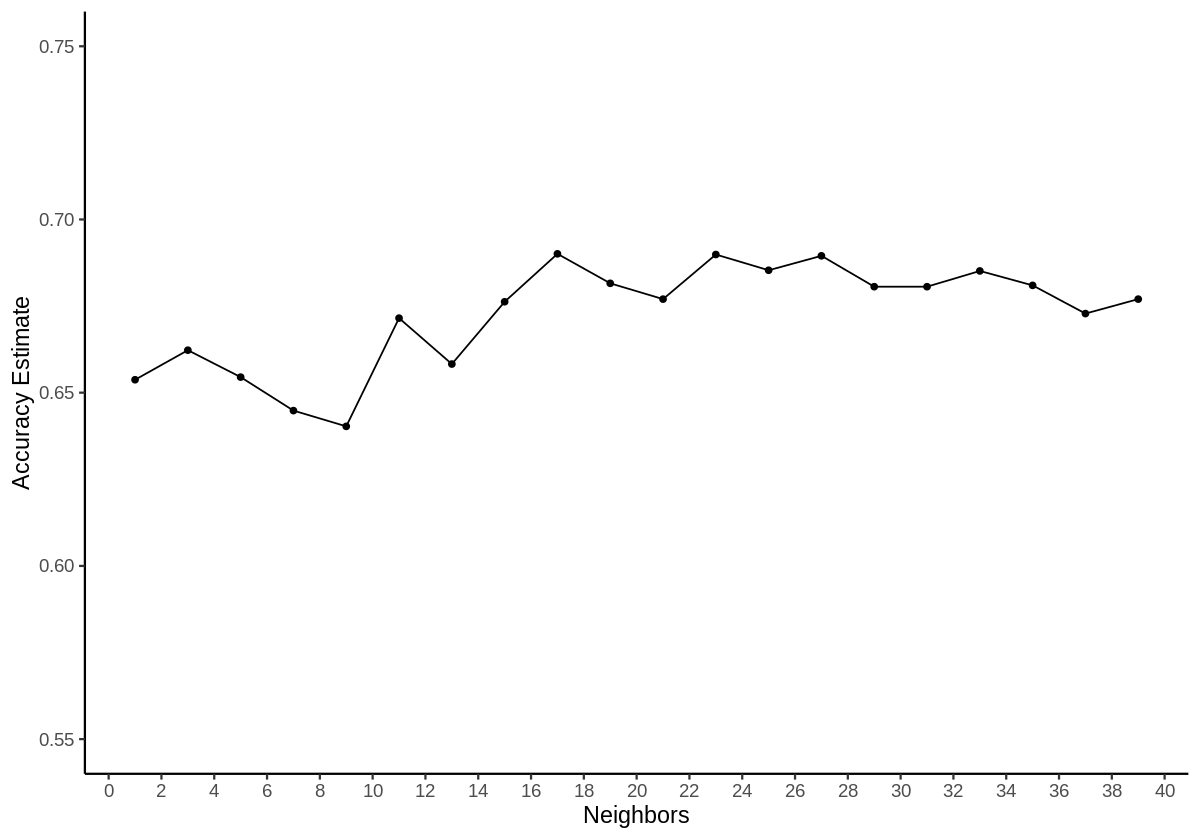

In [43]:
options(repr.plot.width=10, repr.plot.height=7)
# accuracy
accuracy_versus_k <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 40, by = 2)) + # adjusting the x-axis
       scale_y_continuous(limits = c(0.55, 0.75)) + # adjusting the y-axis 
       theme(text=element_text(size = 20)) +
       theme_classic(base_size = 14)

accuracy_versus_k


We extract the number of neighbors associated with the highest accuracy estimate and save that value as appropriate_k. We can also visually see that the accuracy of the model peaks around K = 17 which provides a high accuracy model and changing the K value to a nearby one doesn’t decrease accuracy too much, so that our choice is reliable in the presence of uncertainty. 

In [44]:
appropriate_k <- accuracy %>%
                arrange(-mean) %>%
                slice(1) %>%
                select(neighbors) %>%
                pull()
appropriate_k


[1] 17

## Using the Model

### 2.6 Training the Classifier
Next, we create our final model specification using appropriate_k as the number of nearest neighbors and fit the model to our training set to create our finalized classifier.

In [45]:
set.seed(2022)
# final model specification
knn_spec_new <- nearest_neighbor(weight_func = "rectangular", neighbor = appropriate_k) %>%
            set_engine("kknn") %>%
            set_mode("classification")

# workflow
heart_fit <- workflow() %>%
                    add_model(knn_spec_new) %>%
                    add_recipe(knn_recipe) %>%
                    fit(data = heart_train)

### 2.7 Predicting the Testing Set
We use our finalized trained KNN classfication model to predict heart disease in patients in our testing set. We then bind the predictions produced by our model with the original testing set, so that we can compare our predictions to the true class values.

In [46]:
heart_predictions <- predict(heart_fit, heart_test) %>%
                    bind_cols(heart_test)
head(heart_predictions)


.pred_class,age,trestbps,chol,thalach,oldpeak,diagnosis
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
present,63,145,233,150,2.3,absent
absent,41,130,204,172,1.4,absent
absent,57,140,192,148,0.4,absent
absent,56,140,294,153,1.3,absent
absent,56,130,256,142,0.6,present
absent,54,140,239,160,1.2,absent


## 3. Results
Comparing the predictions of our KNN classfication model on the testing data to the actual value, we can evaluate our model's performance by calculating the overall accuracy of our model's predictions. We achieve a final accuracy rate of 77.33 %.

In [48]:
heart_summary <- heart_predictions %>%
                  metrics(truth = diagnosis, estimate = .pred_class) %>%
                  filter(.metric == "accuracy")

heart_accuracy <- heart_summary %>%
                select(.estimate) %>%
                pull()

paste(round(heart_accuracy*100,2), "%")


[1] "77.33 %"

We also put the prediction results into a confusion matrix comparing with the actual results, this allow us to see how many false positives and false negatives our models gave.

In [49]:
heart_conf_mat <- heart_predictions %>%
    conf_mat(truth =diagnosis, estimate = .pred_class)

heart_conf_mat

          Truth
Prediction absent present
   absent      37      13
   present      4      21

Our model gave 4 false positives and 13 false negatives. This might not be a very good model to use in a medical field as false negatives may lead to a misdiagnosis of heart disease and patient will not be treated in time for their condition. However, our model produced a relatively low number of false positives. This could be good in a medical perspective in that not a lot of patients will have to go through additional invasive tests uneccessarily. 

# 3.0 Methods <a id='methods'></a>

With the following key variables that seem to display a correlation, we will create a K-nearest neighbour (KNN) classification model to predict heart disease:
- Age
- Serum Cholesterol
- Maximum Heart Rate
- ST depression induced by exercise
- Resting Blood Pressure

Our model will need to be trained, evaluated, and tuned with training and testing sets before predicting heart disease in a new patient. We will split our training set to perform five-fold cross-validation and find the appropriate K-value for our model by plotting K values against the accuracy scores. Then, we will use that KNN model to retrain our entire training dataset and check the accuracy of the testing dataset. We plan to analyze which combinations of predictors will yield the lower prediction error and visualize it with scatter plots with predictors on the x and y axes and colour data points with heart disease diagnosis.

# 4.0 Expected outcomes and significance <a id='outcome-significance'></a>

We expect to find that higher serum cholesterol and lower maximum heart rate increase the likelihood of diagnosis with heart disease. Our classification model finds patterns that support the prediction of heart disease in patients. Therefore, the impact our findings have is spreading awareness of signs of potential fatality to save lives. Future questions may dive deeper into additional factors influencing heart disease. It may indicate the invention of new technology because the discovery predicts one’s health based on this disease. Additionally, it could lead to questions that lead to new ways of prevention and allow for more opportunities for healthier lifestyles.